In [ ]:
!pip install shap
!pip install imblearn

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, classification_report
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,ParameterGrid
import seaborn as sns
from sklearn import model_selection,linear_model, metrics
import xgboost as xgb
import warnings
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from CSV file
df = pd.read_csv('/content/drive/MyDrive/Big data/credit_customers.csv')

In [ ]:
# Display the column names of the DataFrame
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [ ]:
# Display the first few rows of the DataFrame
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [ ]:
# Display a concise summary of the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [ ]:
# Generate descriptive statistics for the numerical columns in the DataFrame
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [ ]:
def summarize_categorical_columns(df):
  #Summarizes the categorical columns of a DataFrame.
    summary = []
    n = 1
    for column_name, column_data in df.items():
        if column_data.dtype == 'O':  # Check if the column is of object type (categorical)
            unique_values = column_data.unique()
            summary.append({
                'S.no': n,
                'Name': column_name,
                'Unique Values': unique_values,
                'Count of Unique Values': len(unique_values)
            })
            n += 1
    return pd.DataFrame(summary)

# Summarize the categorical columns
categorical_summary = summarize_categorical_columns(df)
print(categorical_summary)

    S.no                 Name  \
0      1      checking_status   
1      2       credit_history   
2      3              purpose   
3      4       savings_status   
4      5           employment   
5      6      personal_status   
6      7        other_parties   
7      8   property_magnitude   
8      9  other_payment_plans   
9     10              housing   
10    11                  job   
11    12        own_telephone   
12    13       foreign_worker   
13    14                class   

                                        Unique Values  Count of Unique Values  
0                  [<0, 0<=X<200, no checking, >=200]                       4  
1   [critical/other existing credit, existing paid...                       5  
2   [radio/tv, education, furniture/equipment, new...                      10  
3   [no known savings, <100, 500<=X<1000, >=1000, ...                       5  
4               [>=7, 1<=X<4, 4<=X<7, unemployed, <1]                       5  
5   [male single, female

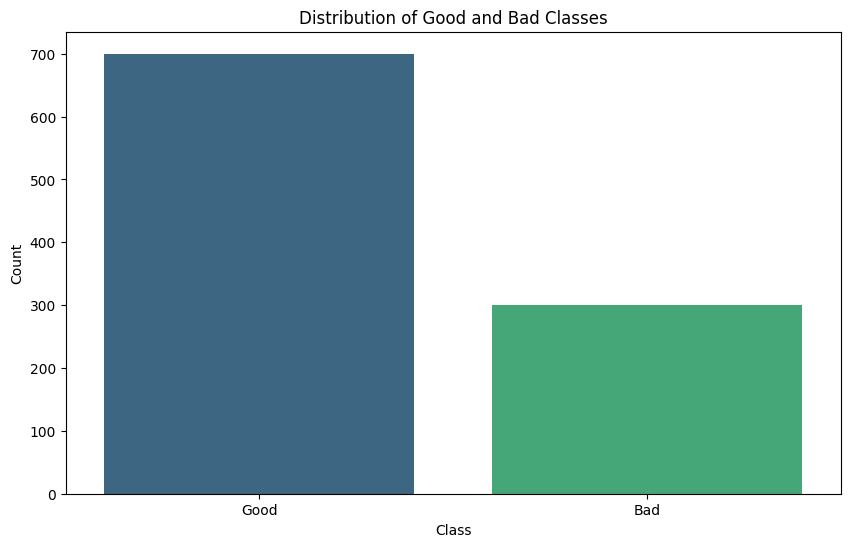

Class Distribution:
class
good    700
bad     300
Name: count, dtype: int64


In [ ]:
# Set up the figure size for the plot
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df, palette='viridis') # Create a count plot for the 'class' column in the DataFrame
plt.title('Distribution of Good and Bad Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Good', 'Bad'])
plt.show()# Display the plot
class_counts = df['class'].value_counts()# Count the occurrences of each unique value in the 'class' column
print("Class Distribution:")
print(class_counts)


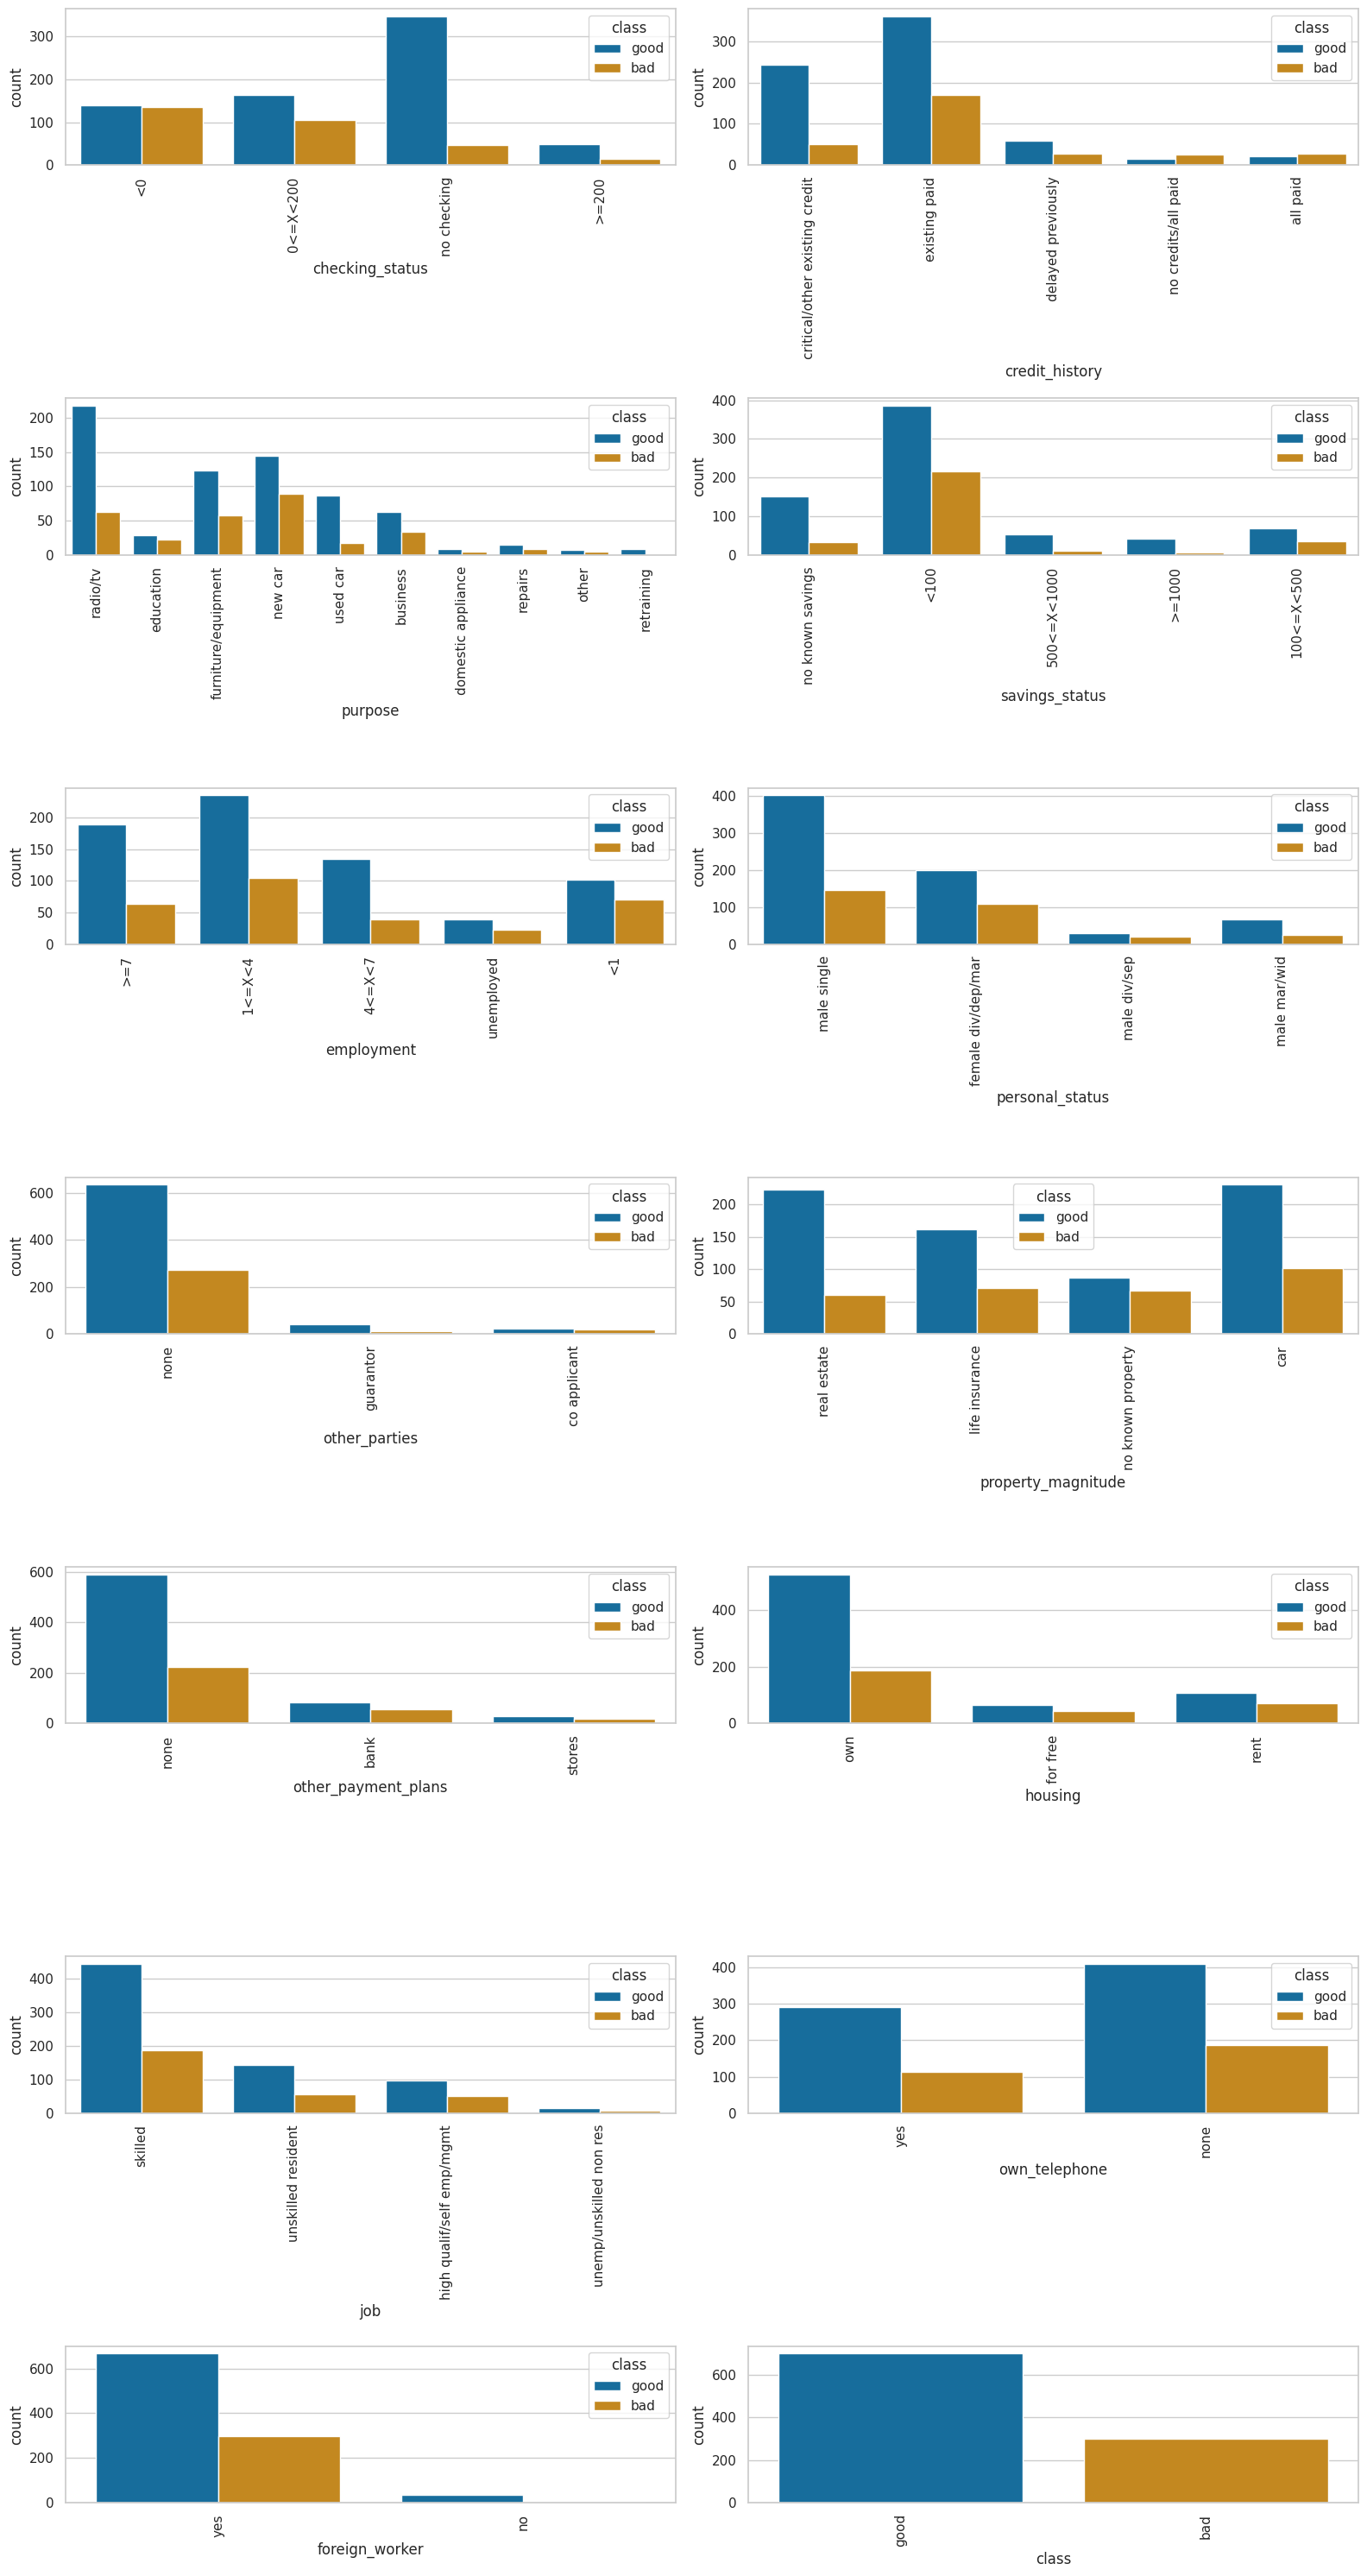

In [ ]:
sns.set_theme(style="whitegrid", palette="colorblind")
plt.figure(figsize=(16, 30))# Initialize a figure with a large size to accommodate multiple subplots
category_list = df.select_dtypes(include='object').columns# Select columns with object data type (categorical columns)
num_columns = 2
num_rows = (len(category_list) + 1) // num_columns
# Loop through each categorical column to create individual subplots
for index, column in enumerate(category_list, start=1):
    plt.subplot(num_rows, num_columns, index)
    plt.xticks(rotation=90)
    sns.countplot(x=column, hue='class', data=df)
    plt.tight_layout()

# Display the entire figure with all subplots
plt.show()


In [ ]:
#Encodes all categorical (object type) columns in the DataFrame using label encoding.
def label_encode_dataframe(df):
    label_encoders = {}# Initialize an empty dictionary to store the LabelEncoders for each column
    encoded_df = df.copy()
    object_cols = df.select_dtypes(include='object').columns# Select columns with object data type (categorical)
    for col in object_cols:# Iterate over each categorical column
        le = LabelEncoder()# Initialize a LabelEncoder for the column
        encoded_df[col] = le.fit_transform(df[col])# Apply label encoding to the column and store it in the encoded DataFrame
        label_encoders[col] = le
    return encoded_df, label_encoders

# Apply label encoding to the DataFrame
encoded_df, encoders = label_encode_dataframe(df)

In [ ]:
#Plots a heatmap of the correlation matrix for the given DataFrame.
def plot_correlation_heatmap(df, title="Correlation Between The Dimensions"):
    plt.figure(figsize=(15, 12))# Set the size of the entire figure
    sns.heatmap(
        encoded_df.corr(),# Compute the correlation matrix of the DataFrame and plot it
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        cmap='coolwarm',
        annot_kws={"size": 10}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()# Display the heatmap
# Call the function to plot the correlation heatmap of the encoded DataFrame
plot_correlation_heatmap(encoded_df)

NameError: name 'encoded_df' is not defined

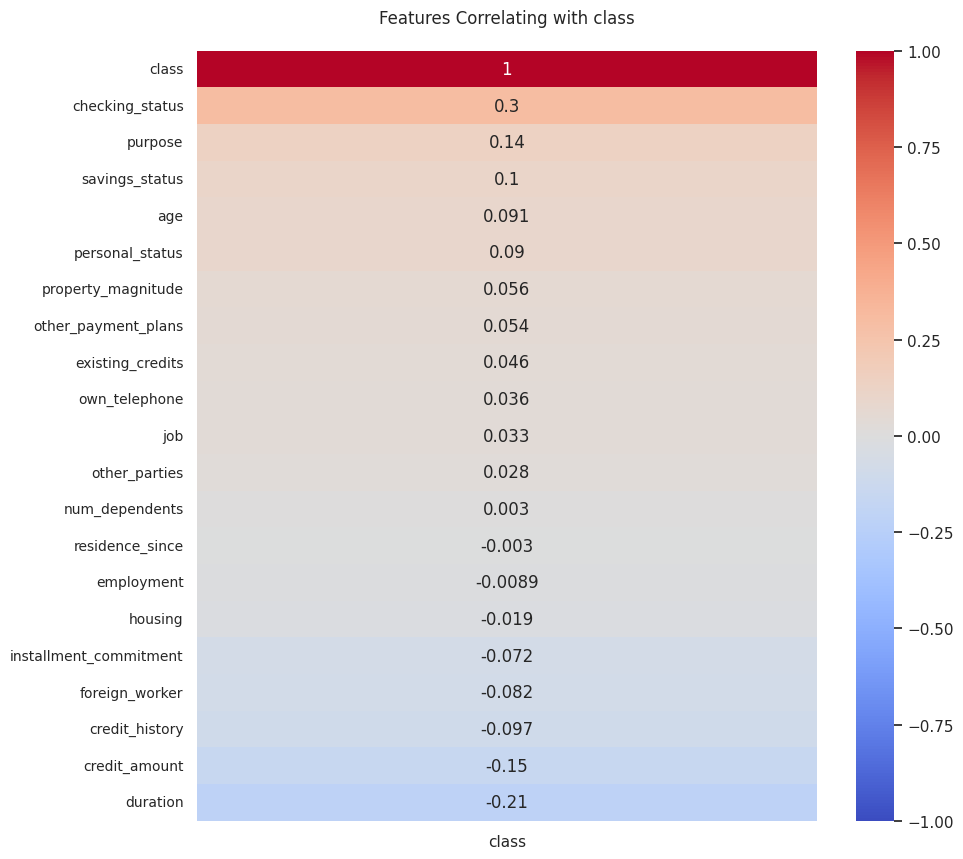

In [ ]:
#Plots a heatmap of the correlation between all features and the target column in the DataFrame.
def plot_class_correlation_heatmap(df, target_column='class'):
    # Set the figure size
    plt.figure(figsize=(10, 10), dpi=100)# Set the figure size and resolution
    # Create the heatmap showing correlations of all features with the target column
    heatmap = sns.heatmap(
        encoded_df.corr()[[target_column]].sort_values(by=target_column, ascending=False),
        vmin=-1, vmax=1, annot=True, cmap='coolwarm'
    )
    heatmap.set_title(f'Features Correlating with {target_column}', fontdict={'fontsize':12}, pad=20)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=10)
    plt.show()
# Call the function to plot the correlation heatmap with the 'class' column
plot_class_correlation_heatmap(encoded_df)

In [ ]:
df['log_credit_amount'] = np.log1p(df['credit_amount'])
df['log_duration'] = np.log1p(df['duration'])

# Interaction features
df['amount_duration_interaction'] = df['credit_amount'] * df['duration']

# Polynomial features
df['credit_amount_squared'] = df['credit_amount'] ** 2
df['duration_squared'] = df['duration'] ** 2

# Aggregation
df['average_credit_amount_by_purpose'] = df.groupby('purpose')['credit_amount'].transform('mean')

df['log_credit_amount'] = np.log1p(df['credit_amount'])
df['log_duration'] = np.log1p(df['duration'])

# Interaction features
df['amount_duration_interaction'] = df['credit_amount'] * df['duration']

# Polynomial features
df['credit_amount_squared'] = df['credit_amount'] ** 2
df['duration_squared'] = df['duration'] ** 2

# Aggregation
df['average_credit_amount_by_purpose'] = df.groupby('purpose')['credit_amount'].transform('mean')

# Frequency Encoding
frequency_encoding = df['purpose'].value_counts().to_dict()
df['purpose_frequency'] = df['purpose'].map(frequency_encoding)

# Lag Features (Example: Lag 1 for duration)
df['lag1_duration'] = df['duration'].shift(1).fillna(0)

# Rolling Statistics (Example: Rolling mean and std for duration)
df['rolling_mean_duration'] = df['duration'].rolling(window=3).mean().fillna(0)
df['rolling_std_duration'] = df['duration'].rolling(window=3).std().fillna(0)

In [ ]:
mean_item_amount = df.groupby('purpose')['credit_amount'].mean().to_dict()
std_item_amount = df.groupby('purpose')['credit_amount'].std().to_dict()
#Classifies the 'credit_amount' of a row as 'high' or 'normal' based on the mean and standard deviation for the 'purpose' category of that row.
def classify_credit_amount(row):
    mean = mean_item_amount[row['purpose']]
    std = std_item_amount[row['purpose']]
    return 'high' if row['credit_amount'] > mean + 0.5 * std else 'normal'

# Apply the classification function to each row in the DataFrame
df['credit_amount_ratio'] = df.apply(classify_credit_amount, axis=1)
df['monthly_return'] = df['credit_amount'] / df['duration']# Calculate the monthly return by dividing the 'credit_amount' by 'duration' and create a new column
df['duration_age_ratio'] = 100 * df['duration'] / (12 * df['age'])# Calculate the duration to age ratio, scale by 100, and create a new column
df[['sex', 'marriage']] = df['personal_status'].str.split(" ", expand=True)# Split the 'personal_status' column into 'sex' and 'marriage' columns
df.drop(['personal_status', 'marriage'], axis=1, inplace=True)
# Replace values in the 'credit_history' column to group categories
df['credit_history'].replace({
    'critical/other existing credit': 'existing paid',
    'delayed previously': 'delayed previously',
    'existing paid': 'existing paid',
    'no credits/all paid': 'all paid',
    'all paid': 'all paid'
}, inplace=True)
# Replace values in the 'employment' column to classify employment stability
df['employment'].replace({
    'unemployed': 'unstable',
    '<1': 'unstable',
    '1<=X<4': 'stable',
    '4<=X<7': 'stable',
    '>=7': 'stable'
}, inplace=True)
# Replace values in the 'job' column to group job categories
df['job'].replace({
    'unemp/unskilled non res': 'unskilled resident',
    'unskilled resident': 'unskilled resident',
    'skilled': 'skilled',
    'high qualif/self emp/mgmt': 'high qualif/self emp/mgmt'
}, inplace=True)

# Replace values in the 'housing' column to group housing status
df['housing'].replace({
    'for free': 'dont own',
    'rent': 'dont own',
    'own': 'own'
}, inplace=True)

# Replace values in the 'other_payment_plans' column to group payment plans
df['other_payment_plans'].replace({
    'none': 'non',
    'stores': 'exist',
    'bank': 'exist'
}, inplace=True)
# Replace values in the 'property_magnitude' column to group property status
df['property_magnitude'].replace({
    'no known property': 'no known property',
    'life insurance': 'exist',
    'car': 'exist',
    'real estate': 'exist'
}, inplace=True)

df.head()


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,other_parties,residence_since,...,duration_squared,average_credit_amount_by_purpose,purpose_frequency,lag1_duration,rolling_mean_duration,rolling_std_duration,credit_amount_ratio,monthly_return,duration_age_ratio,sex
0,<0,6.0,existing paid,radio/tv,1169.0,no known savings,stable,4.0,none,4.0,...,36.0,2487.653571,280,0.0,0.0,0.000000,normal,194.833333,0.746269,male
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,stable,2.0,none,2.0,...,2304.0,2487.653571,280,6.0,0.0,0.000000,high,123.979167,18.181818,female
2,no checking,12.0,existing paid,education,2096.0,<100,stable,2.0,none,3.0,...,144.0,3180.400000,50,48.0,22.0,22.715633,normal,174.666667,2.040816,male
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,stable,2.0,guarantor,4.0,...,1764.0,3066.988950,181,12.0,34.0,19.287302,high,187.666667,7.777778,male
4,<0,24.0,delayed previously,new car,4870.0,<100,stable,3.0,none,4.0,...,576.0,3063.025641,234,42.0,26.0,15.099669,high,202.916667,3.773585,male


In [ ]:
# Creating age groups
def create_age_group(df):
    age_bins = [0, 30, 40, 50, 60, 70, 120]
    age_labels = ['0-30', '31-40', '41-50', '51-60', '61-70', '70+']
    df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True).astype(object)
    df.drop(columns=['age'], inplace=True)

# Creating duration groups
def create_duration_group(df):
    duration_bins = [0, 12, 24, 36, 48, 60, 72]
    duration_labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
    df['duration_group'] = pd.cut(df['duration'], bins=duration_bins, labels=duration_labels, include_lowest=True).astype(object)
    df.drop(columns=['duration'], inplace=True)

# Creating duration_age_ratio groups
def create_duration_age_ratio_group(df):
    ratio_bins = [0, 2.5, 5, 7.5, 10, 12.5, 120]
    ratio_labels = ['0-2.5', '2.5-5', '5-7.5', '7.5-10', '10-12.5', '12.5+']
    df['duration_age_ratio_group'] = pd.cut(df['duration_age_ratio'], bins=ratio_bins, labels=ratio_labels, include_lowest=True).astype(object)
    df.drop(columns=['duration_age_ratio'], inplace=True)

# Creating monthly_return groups
def create_monthly_return_group(df):
    return_bins = [0, 50, 100, 150, 200, 250, 50000]
    return_labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251+']
    df['monthly_return_group'] = pd.cut(df['monthly_return'], bins=return_bins, labels=return_labels, include_lowest=True).astype(object)
    df.drop(columns=['monthly_return'], inplace=True)

# Creating credit_amount groups
def create_credit_amount_group(df):
    amount_bins = [0, 500, 1000, 1500, 2000, 2500, 50000]
    amount_labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501+']
    df['credit_amount_group'] = pd.cut(df['credit_amount'], bins=amount_bins, labels=amount_labels, include_lowest=True).astype(object)
    df.drop(columns=['credit_amount'], inplace=True)

# Apply group creation functions
create_age_group(df)
create_duration_group(df)
create_duration_age_ratio_group(df)
create_monthly_return_group(df)
create_credit_amount_group(df)

df.head()
df.to_csv("df.csv")


In [ ]:
# Encodes all categorical (object type) columns in the DataFrame using label encoding.
def label_encode_dataframe(df):
    label_encoders = {} #Initialize an empty dictionary to store the LabelEncoders for each column
    encoded_df = df.copy()
    object_cols = df.select_dtypes(include='object').columns # Select columns with object data type (categorical)
    for col in object_cols:# Iterate over each categorical column
        le = LabelEncoder()# Initialize a LabelEncoder for the column
        encoded_df[col] = le.fit_transform(df[col]) # Apply label encoding to the column and store it in the encoded DataFrame
        label_encoders[col] = le
    return encoded_df, label_encoders
# Apply label encoding to the DataFrame
encoded_df, encoders = label_encode_dataframe(df)


In [ ]:
# Splitting data into training and testing sets
y = encoded_df['class']
X = encoded_df.drop(['class'], axis=1)
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [ ]:
def evaluate_model(model, model_name, x_train, y_train, x_test, y_test):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        # Train the model
        start_time = time.time()
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        # Predict probabilities and labels
        pred_proba = model.predict_proba(x_test)[:, 1]
        pred = model.predict(x_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, pred)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, pred, average='binary')
        roc_auc = roc_auc_score(y_test, pred_proba)
        fpr, tpr, _ = roc_curve(y_test, pred_proba)

        # Compile results
        results = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F-Score': fscore,
            'ROC AUC': roc_auc,
            'Training Time': training_time
        }

        # Display results
        results_df = pd.DataFrame([results])
        results_df.to_csv(f'results_{model_name}.csv', index=False)
        print(results_df)

        # Plot ROC curve
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.show()

        # Plot feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'Feature': x_train.columns,
                'Importance': model.feature_importances_
            }).sort_values(by='Importance', ascending=True)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
            plt.title(f'Feature Importances - {model_name}')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_test, pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu', cbar=False, xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

#Basic model


Time taken for basic training -1723299813.612155 seconds
                                     Model  Accuracy      Time
2                      Logistic Regression     0.810  0.013691
10                     AdaBoost Classifier     0.795  0.154289
6                Support Vector Classifier     0.795  0.035587
3                           Neural Network     0.780  0.874224
0                 Random Forest Classifier     0.780  0.324533
4                                  XGBoost     0.775  0.192903
8             Gradient Boosting Classifier     0.770  0.291550
5   Stochastic Gradient Descent Classifier     0.755  0.011441
7                     Gaussian Naive Bayes     0.740  0.003421
1                 Decision Tree Classifier     0.735  0.010903
9           K-Nearest Neighbors Classifier     0.730  0.012884


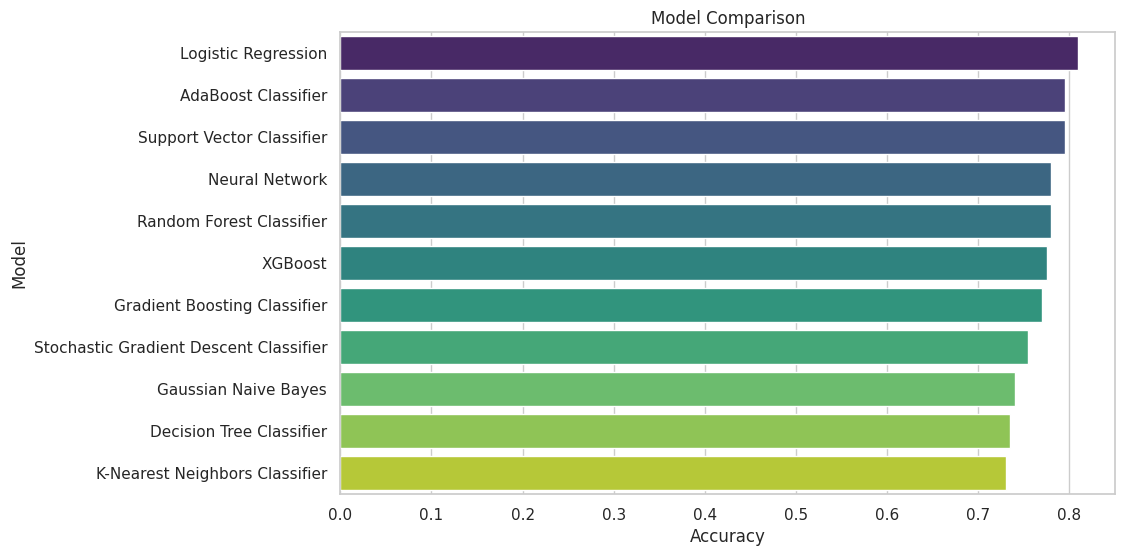

In [ ]:

# Define models
models = {
    'Random Forest Classifier': RandomForestClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Neural Network': MLPClassifier(),
    'XGBoost': XGBClassifier(),
    'Stochastic Gradient Descent Classifier': SGDClassifier(),
    'Support Vector Classifier': svm.SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier()
}

results = []

# Suppress convergence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for name, model in models.items():
        start = time.time()
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        end = time.time() - start
        results.append({
            'Model': name,
            'Accuracy': score,
            'Time': end
        })

print("Time taken for basic training", end - start, "seconds")
# Convert results to DataFrame for better presentation
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(results_df)


plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    params = {
        'n_estimators': [10, 100, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
        'min_samples_split': [3, 4, 5, 6, 8, 10, 12, 15],
        'min_samples_leaf': [1, 2, 3, 4],
        'bootstrap': [True, False]
    }

    rf_random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, n_iter=15, scoring="accuracy", n_jobs=-1, cv=10, verbose=0)
    rf_random_search.fit(x_train, y_train)


In [ ]:
rf_random_search.best_params_

In [ ]:
start = time.time()
rf_model = RandomForestClassifier(**rf_random_search.best_params_)
rf_model.fit(x_train, y_train)


end = time.time()
print("Random Forest training took", end - start, "seconds")

In [ ]:
evaluate_model(rf_model, 'Random Forest Classifier', x_train, y_train, x_test, y_test)


In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

#select SHAP values for the positive class
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_for_positive_class = shap_values[1]
else:
    shap_values_for_positive_class = shap_values
if shap_values_for_positive_class.ndim == 3:
    shap_values_for_positive_class = shap_values_for_positive_class[:, :, 0]
# Plot SHAP summary plot
shap.summary_plot(shap_values_for_positive_class, X, plot_type="dot")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs', 'liblinear', 'saga']
    }

    log_reg = LogisticRegression(max_iter=1000)
    log_reg_cv = RandomizedSearchCV(log_reg, param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='accuracy')
    log_reg_cv.fit(x_train, y_train)

In [ ]:
print("Best hyperparameters for Logistic Regression:", log_reg_cv.best_params_)

Best hyperparameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'none', 'C': 0.08858667904100824}


In [ ]:
best_log_reg = log_reg_cv.best_estimator_
best_log_reg.fit(x_train, y_train)

LogisticRegression(C=0.08858667904100824, max_iter=1000, penalty='none')

                             Model  Accuracy  Precision    Recall   F-Score  \
0  Losgistic Regression Classifier      0.72   0.748428  0.881481  0.809524   

    ROC AUC  Training Time  
0  0.759886       0.047584  


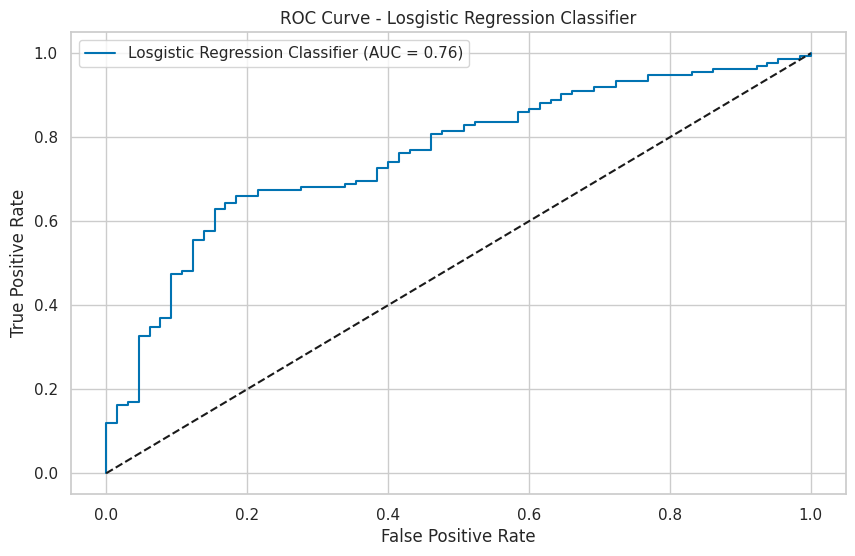

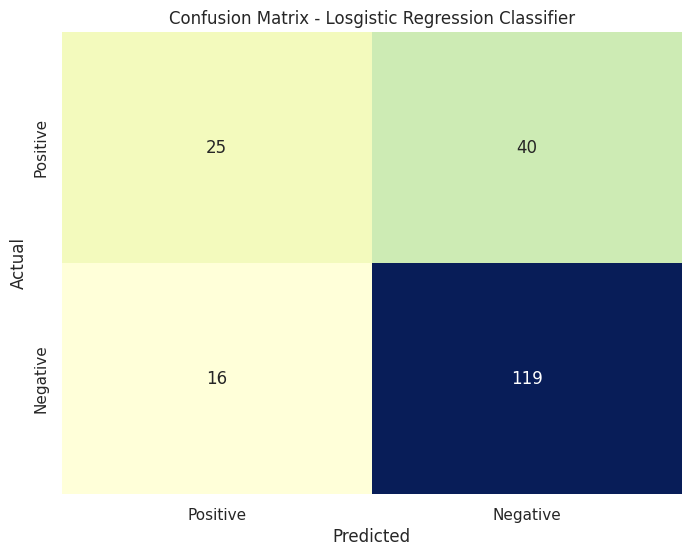

In [ ]:
evaluate_model(best_log_reg, 'Losgistic Regression Classifier', x_train, y_train, x_test, y_test)


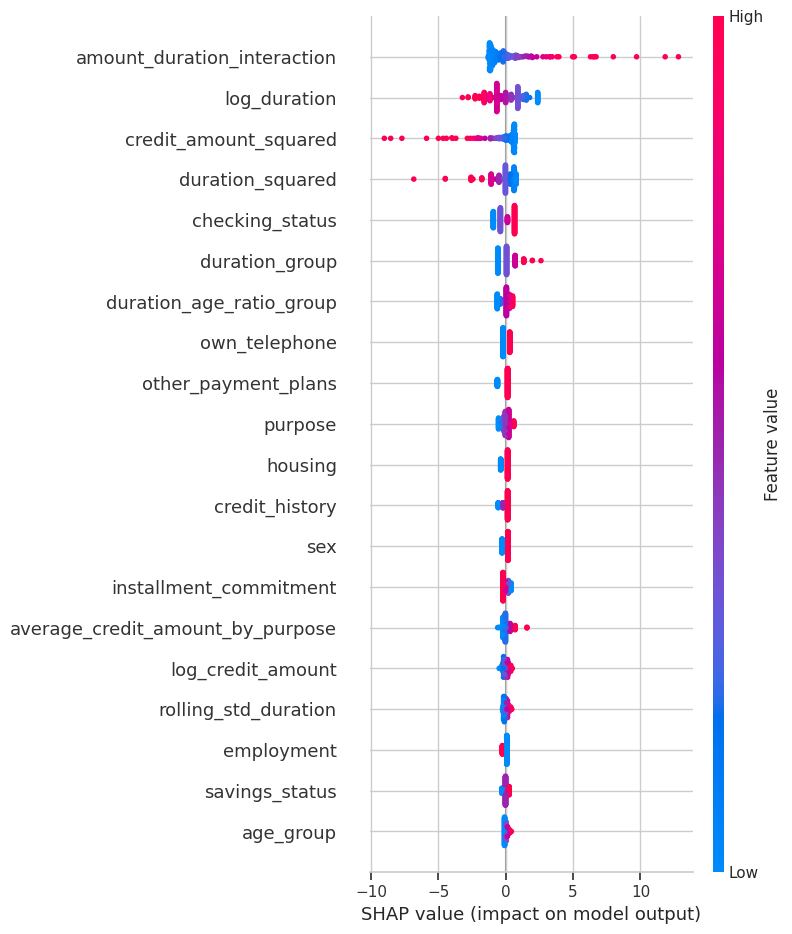

In [ ]:
explainer = shap.Explainer(best_log_reg, x_test)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns, plot_type="dot")

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='accuracy')
xgb_cv.fit(x_train, y_train)
print("Best hyperparameters for XGBoost:", xgb_cv.best_params_)


Best hyperparameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.7}


In [ ]:
best_xgb = xgb_cv.best_estimator_
best_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

                Model  Accuracy  Precision   Recall   F-Score   ROC AUC  \
0  XGBoost Classifier     0.725   0.777778  0.82963  0.802867  0.726952   

   Training Time  
0       0.107677  


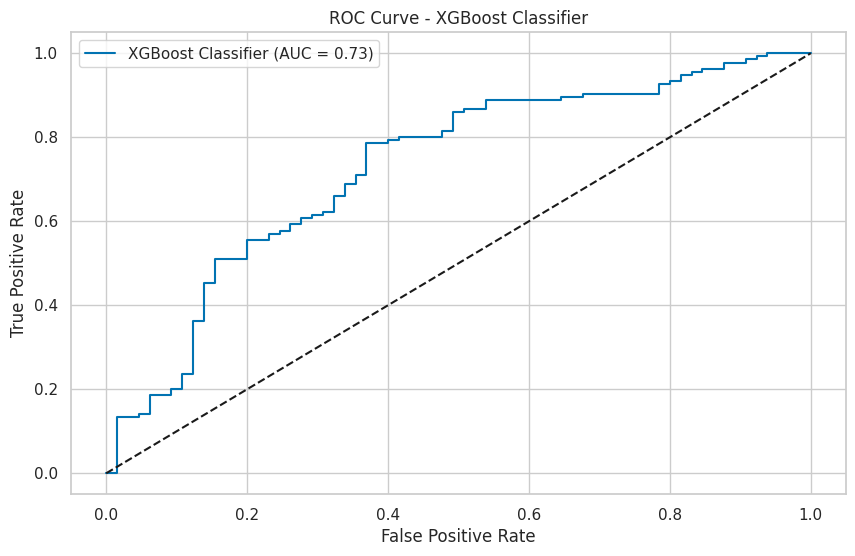

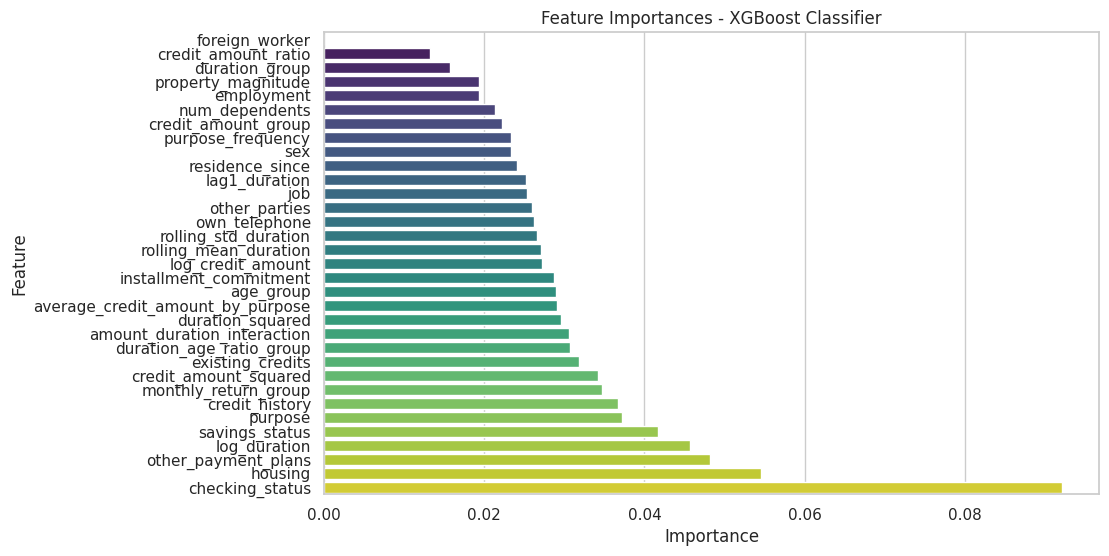

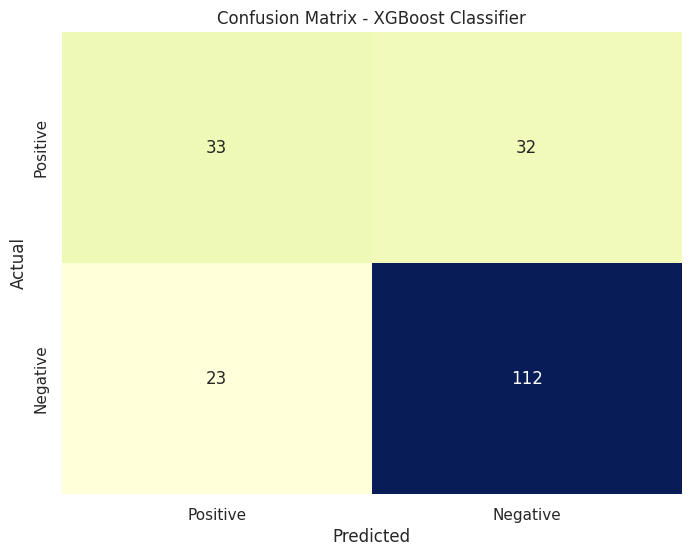

In [ ]:
evaluate_model(best_xgb, 'XGBoost Classifier', x_train, y_train, x_test, y_test)


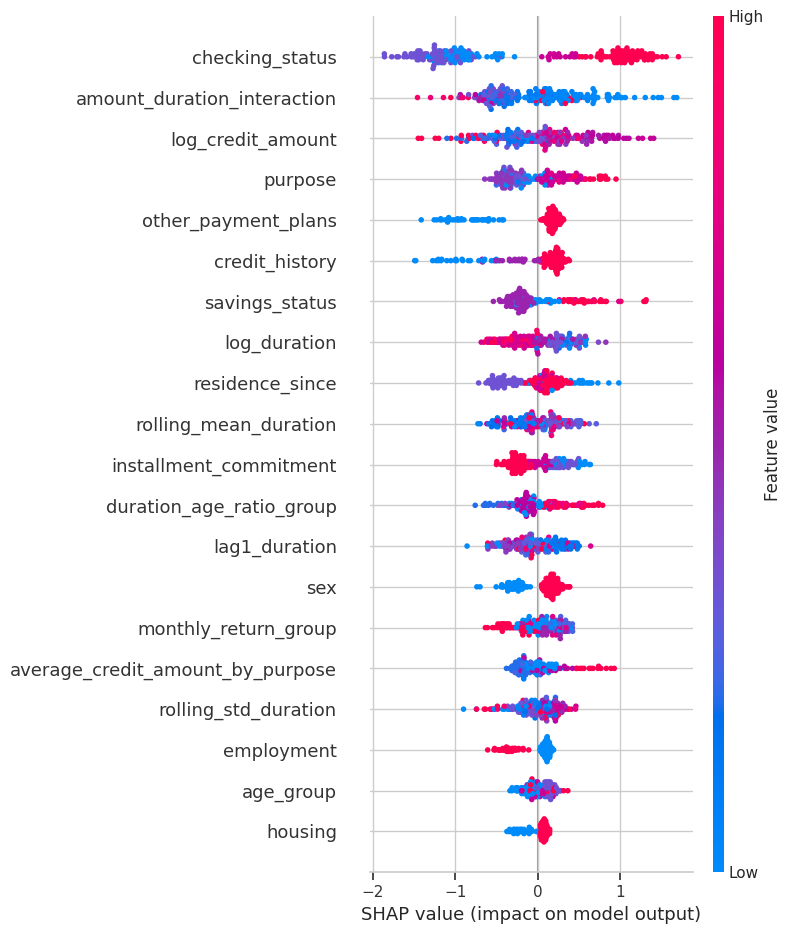

In [ ]:
explainer = shap.Explainer(best_xgb, x_test)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns, plot_type="dot")

In [ ]:

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svm = SVC(probability=True)
svm_cv = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='accuracy')
svm_cv.fit(x_train, y_train)
print("Best hyperparameters for SVM:", svm_cv.best_params_)

Best hyperparameters for SVM: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 1000}


In [ ]:
best_svm = svm_cv.best_estimator_
best_svm.fit(x_train, y_train)

SVC(C=1000, gamma=0.001, kernel='sigmoid', probability=True)

In [ ]:
evaluate_model(best_svm, 'SVM Classifier', x_train, y_train, x_test, y_test)


In [ ]:
explainer = shap.KernelExplainer(best_svm.predict, X)
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="dot")

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
mlp = MLPClassifier(max_iter=1000)
mlp_cv = RandomizedSearchCV(mlp, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='accuracy')
mlp_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.001, 0.01,
                                                               0.1],
                                        'solver': ['sgd', 'adam']},
                   random_state=42, scoring='accuracy')

In [ ]:
print("Best hyperparameters for MLPClassifier:", mlp_cv.best_params_)


Best hyperparameters for MLPClassifier: {'solver': 'sgd', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
best_mlp = mlp_cv.best_estimator_
best_mlp.fit(x_train, y_train)

MLPClassifier(activation='tanh', learning_rate='adaptive', max_iter=1000,
              solver='sgd')

                              Model  Accuracy  Precision    Recall  F-Score  \
0  Multi layer percepton Classifier     0.765   0.759259  0.938931  0.83959   

    ROC AUC  Training Time  
0  0.823653       4.734415  


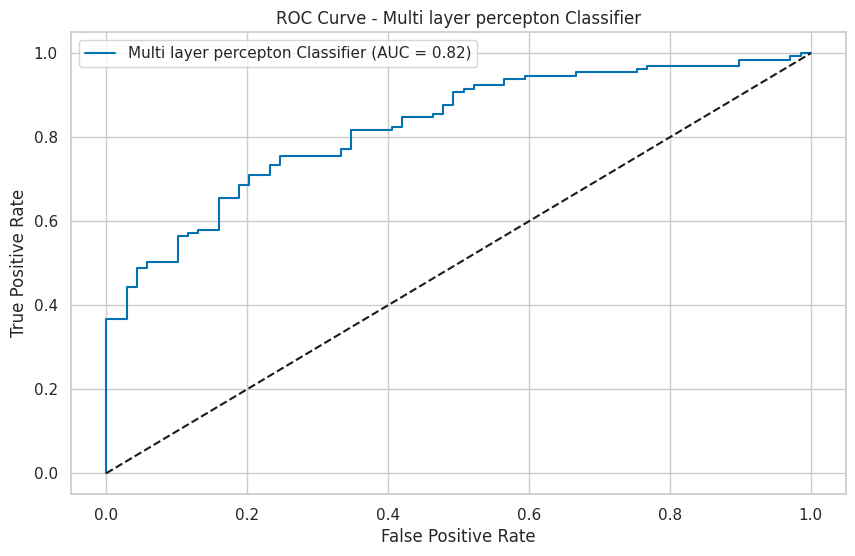

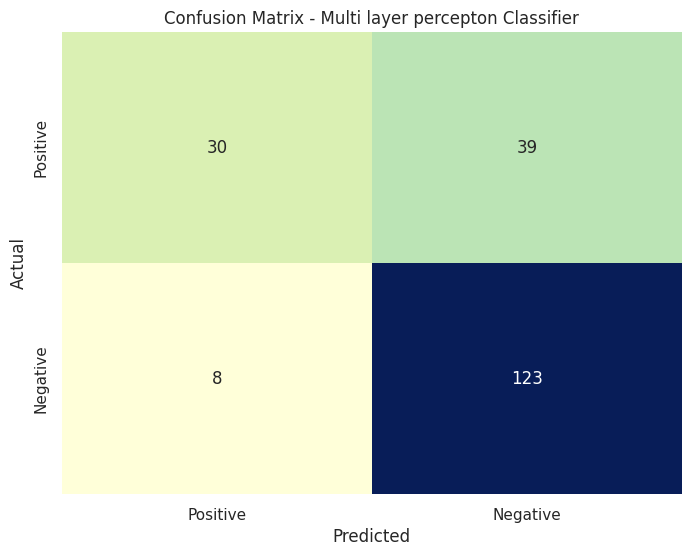

In [ ]:
evaluate_model(best_mlp, 'Multi layer percepton Classifier', x_train, y_train, x_test, y_test)


Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}, Accuracy: 0.78
Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}, Accuracy: 0.775
Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}, Accuracy: 0.725
Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>}, Accuracy: 0.79
Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>}, Accuracy: 0.83
Params: {'dropout_rate': 0.3, 'epochs': 50, 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>}, Accuracy: 0.775
Params: {'dropout_rate': 0.3, 'epochs': 100, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}, Accuracy: 0.745
Params: {'dropout_rate': 0.3, 'epochs': 100, 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}, Accuracy: 0.775
Params: {'dropout_rate': 0.3, 'epochs': 100, 'lr': 0.01

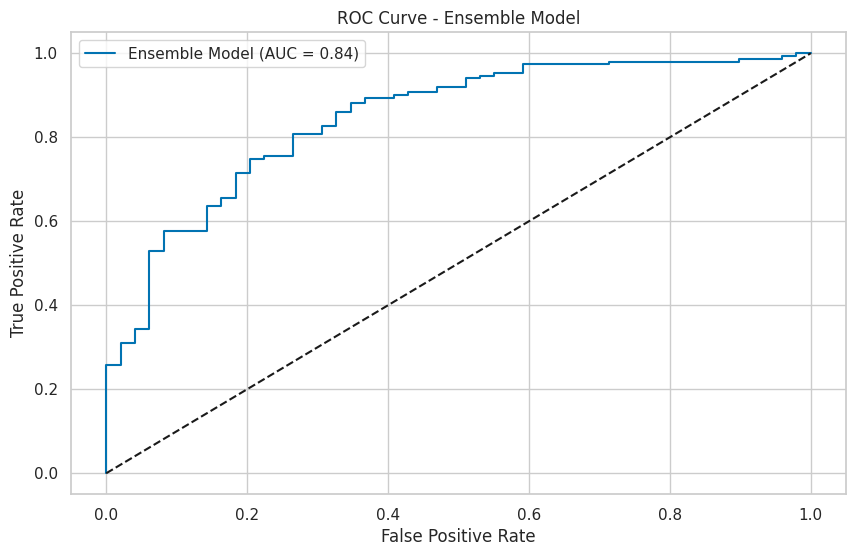

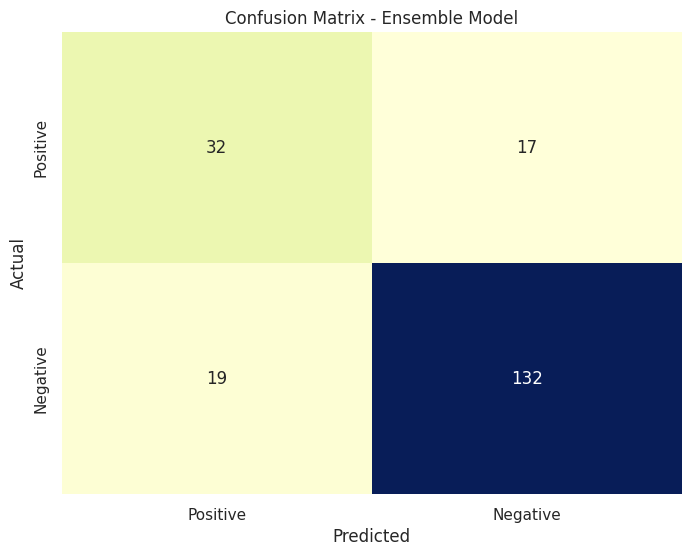

In [ ]:

x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define
class NeuralNet(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

#evaluate a single model
def evaluate_model_pytorch(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds)

# evaluate the ensemble
def evaluate_model_ensemble(model_name, y_test, ensemble_predictions):
    pred_proba = ensemble_predictions.mean(axis=1)
    pred = (pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, pred, average='binary')
    roc_auc = roc_auc_score(y_test, pred_proba)
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F-Score': fscore,
        'ROC AUC': roc_auc,
    }
    results_df = pd.DataFrame([results])
    results_df.to_csv(f'results_{model_name}.csv', index=False)
    print(results_df)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu', cbar=False, xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Set up the parameters
param_grid = {
    'dropout_rate': [0.3, 0.5, 0.7],
    'lr': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
    'optimizer': [optim.Adam, optim.SGD]
}

# Perform grid search to train and evaluate models
best_models = []
best_scores = []
ensemble_predictions = np.zeros((x_test_tensor.shape[0], 5))

# Create DataLoader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for params in ParameterGrid(param_grid):
    model = NeuralNet(input_dim=x_train.shape[1], dropout_rate=params['dropout_rate'])
    criterion = nn.BCELoss()
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])

    #x_train and y_train into DataLoader for batch processing
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Train the model
    train_model(model, criterion, optimizer, train_loader, epochs=params['epochs'])

    # Evaluate the model
    preds = evaluate_model_pytorch(model, test_loader)

    # Store the best models based on accuracy
    accuracy = accuracy_score(y_test_tensor.numpy(), (preds > 0.5).astype(int))
    print(f"Params: {params}, Accuracy: {accuracy}")

    if len(best_scores) < 5:
        best_scores.append(accuracy)
        best_models.append(model)
    else:
        min_score_idx = np.argmin(best_scores)
        if accuracy > best_scores[min_score_idx]:
            best_scores[min_score_idx] = accuracy
            best_models[min_score_idx] = model

# Combine predictions from the best 5 models
for i, model in enumerate(best_models):
    preds = evaluate_model_pytorch(model, test_loader)
    ensemble_predictions[:, i] = preds.flatten()

# Evaluate the ensemble model on the test set
evaluate_model_ensemble("Ensemble Model", y_test_tensor.numpy(), ensemble_predictions)
